In [1]:
import torch 
import numpy as np
from typing import Sequence

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from evaluate import evaluate
from data.kernel import *
from data.evaluation import generate_gp_evaluation_task, generate_test_function_evaluation_task
from data.sampler import *
from data.function import *
from policies.pbo import * 
from utils.plot import *
from policies.transformer import * 
%reload_ext autoreload
%autoreload 2

In [47]:
d_x = 2
x_range = torch.tensor([[-5, 10], [0, 15]]) # (d_x, 2)
Xopt = torch.tensor([[-3.142,12.275],[3.142,2.275],[9.42478,2.475]])
yopt = torch.tensor([[0.397887],[0.397887],[0.397887]])
N = 200
points = torch.rand(N + 4, 2) * (x_range[..., 1] - x_range[..., 0]) + x_range[..., 0]
Y = branin2D(points, negate=True, add_dim=True)

In [26]:
SR, CIT, IR, CR = list(), list(), list(), list()
dataset_id=0
for seed_id in range(30): 
    SR.append(torch.load(f"results/evaluation/GP1D/qTS/{str(dataset_id)}/{str(seed_id)}/simple_regret.pt", map_location="cpu"))
    CIT.append(torch.load(f"results/evaluation/GP1D/qTS/{str(dataset_id)}/{str(seed_id)}/cumulative_inference_time.pt", map_location="cpu"))
    IR.append(torch.load(f"results/evaluation/GP1D/qTS/{str(dataset_id)}/{str(seed_id)}/immediate_regret.pt", map_location="cpu"))
    CR.append(torch.load(f"results/evaluation/GP1D/qTS/{str(dataset_id)}/{str(seed_id)}/cumulative_regret.pt", map_location="cpu"))
SR = torch.stack(SR, dim=0)
IR = torch.stack(IR, dim=0)
CIT = torch.stack(CIT, dim=0)
CR = torch.stack(CR, dim=0)

In [27]:
torch.save(SR, f"results/evaluation/GP1D/qTS/{str(dataset_id)}/SIMPLE_REGRET.pt")
torch.save(IR, f"results/evaluation/GP1D/qTS/{str(dataset_id)}/IMMEDIATE_REGRET.pt")
torch.save(CIT, f"results/evaluation/GP1D/qTS/{str(dataset_id)}/CUMULATIVE_INFERENCE_TIME.pt")
torch.save(CR, f"results/evaluation/GP1D/qTS/{str(dataset_id)}/CUMULATIVE_REGRET.pt")

In [7]:
sr = torch.load(f"results/evaluation/GP1D/PABBO/PABBO_GP1D/SIMPLE_REGRET.pt", map_location="cpu")
t = torch.load(f"results/evaluation/GP1D/PABBO/PABBO_GP1D/CUMULATIVE_TIME.pt", map_location="cpu")


In [11]:
print(sr.shape, t.shape)

torch.Size([30, 30, 31]) torch.Size([30, 30, 30])


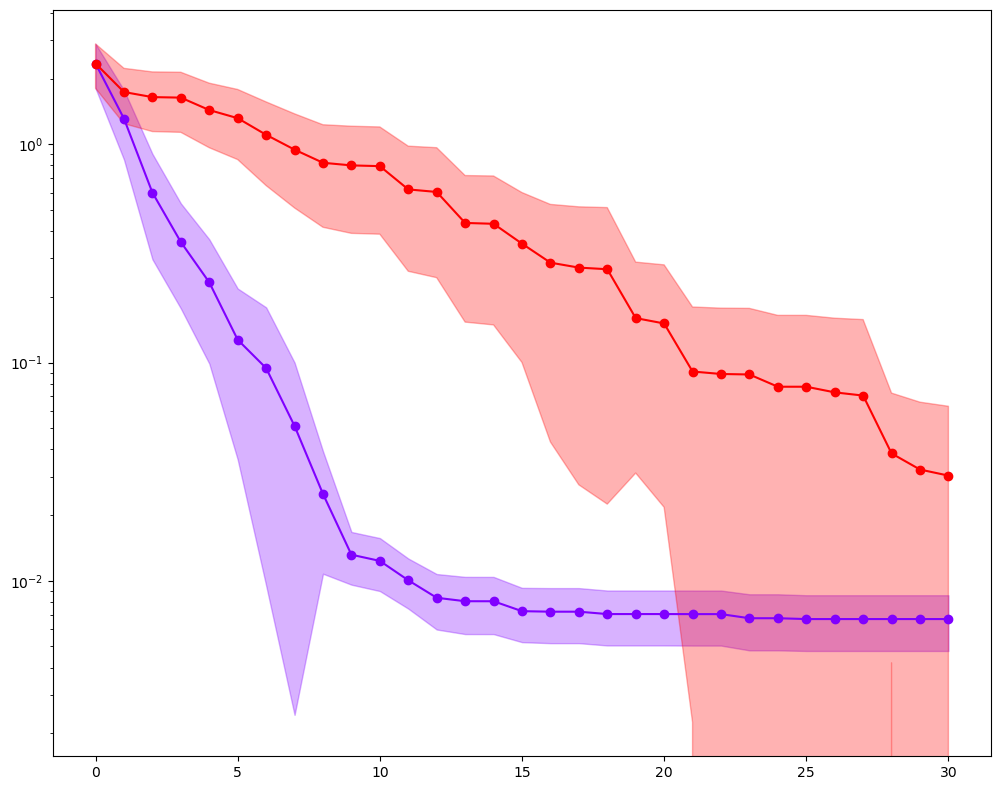

In [28]:

ax = plot_metric_along_trajectory(metrics=[sr[:, dataset_id], SR], model_names=["PABBO", "qTS"])
ax.set_yscale("log")

In [72]:

eval_task = generate_gp_evaluation_task(
            num_seeds=1, 
            num_datasets=2, 
            num_total_points=500,
            num_initial_pairs=1, 
            train_x_range=[[-1, 1]],
            test_x_range=[[-1, 1]], 
            p_noise=0.0, 
            device="cpu",
        )


/scratch/work/zhangx18/PABBO/policies/pbo.py:261: DeprecationWarning: invalid escape sequence \i
  **kwargs,


In [77]:
pbo_handler = PBOHandler()

X, y, comp = pbo_handler.load_pabbo_data(pair = eval_task["initialization"][f"0"]["initial_pairs"][0], 
                            pair_y = eval_task["initialization"][f"0"]["initial_pairs_y"][0], 
                            c = eval_task["initialization"][f"0"]["initial_c"][0])

/scratch/work/zhangx18/PABBO/policies/pbo.py:261: DeprecationWarning: invalid escape sequence \i
  **kwargs,


torch.Size([500, 1]) torch.Size([1, 1])
torch.Size([500, 1])
torch.Size([1, 1])
torch.Size([500, 1]) torch.Size([1, 1])
torch.Size([500, 1])
torch.Size([1, 1])


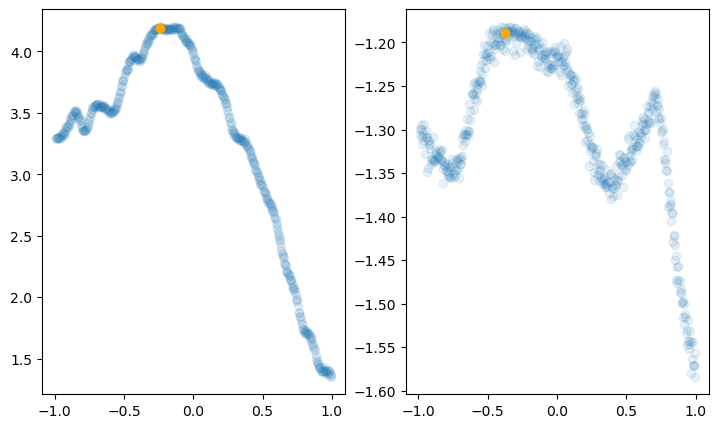

In [36]:
fig = plt.figure(figsize=(18, 5))
for b in range(eval_task["num_datasets"]):
    sampler = SimpleGPSampler(
                    kernel_function=globals()[
                        eval_task["sampler_kwargs"][b]["kernel_function"]
                    ],
                    mean=eval_task["sampler_kwargs"][b]["mean"],
                    jitter=eval_task["sampler_kwargs"][b]["jitter"],
                )
    utility = OptimizationFunction(
                    sampler=sampler, **eval_task["function_kwargs"][b]
    )

    print(utility.train_X.shape, utility.Xopt.shape)
    pred_train_y = utility(utility.train_X)
    
    print(pred_train_y.shape)
    ax = fig.add_subplot(1, 4, b+1)
    ax.scatter(utility.train_X.flatten(), pred_train_y.flatten(), alpha=0.1)
    opt_y = utility(utility.Xopt)
    print(opt_y.shape)
    ax.scatter(utility.Xopt.flatten(), opt_y.flatten(), c="orange")


In [20]:
for k in eval_task:
    print(k)

num_seeds
num_datasets
test_x_range
train_x_range
Xopt
yopt
sampler_kwargs
function_kwargs
initialization


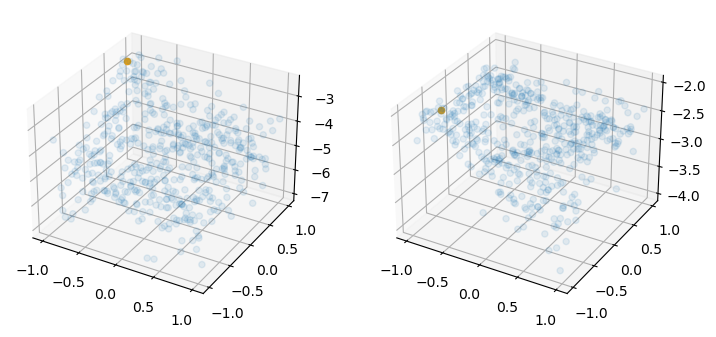

In [26]:
fig = plt.figure(figsize=(18, 5))
for b in range(eval_task["num_datasets"]):
    sampler = SimpleGPSampler(
                    kernel_function=globals()[
                        eval_task["sampler_kwargs"][b]["kernel_function"]
                    ],
                    mean=eval_task["sampler_kwargs"][b]["mean"],
                    jitter=eval_task["sampler_kwargs"][b]["jitter"],
                )
    utility = OptimizationFunction(
                    sampler=sampler, **eval_task["function_kwargs"][b]
    )


    pred_train_y = utility(utility.train_X)

    ax = fig.add_subplot(1, 4, b+1, projection='3d')
    ax.scatter(utility.train_X[:, 0], utility.train_X[:, 1], pred_train_y, alpha=0.1)
    opt_y = utility(utility.Xopt)
    ax.scatter(utility.Xopt[:, 0], utility.Xopt[:, 1], opt_y, c="orange")


We provide a minimal implementation of the source code to reproduce our ablation experiments on meta-training datasets. While we have tried our best to make the code as clear and instructive as possible within the limited time, we apologize for any potential oversights or errors.

**Dependencies**: `pip install -r requirements`

**Experiments**: To evaluate a specific PABBO model, you can use the `evaluate` function from `evaluate.py` as follows:

1. Command Line Execution. 
    
    Run the command:
    ```bash 
    python evaluate.py --model_name PABBO_RBF
    ```
    Here, `model_name` can be either "PABBO_RBF" or "PABBO_Mixture". For convenience, a batch script (`run.sh`) is also provided.

2. Notebook Execution. 
    
    Alternatively, you can execute this notebook. Note that this approach may take quite an amount of time.

Results will be saved in the directory `evaluation/results/model_name` and will include the following three files:

- `SIMPLE_REGRET.pt`
- `STEP_SIMPLE_REGRET.pt`
- `CUMULATIVE_REGRET.pt`

Each file contains a `torch.tensor` of shape `(num_seed, T)`, representing the regrets collected along the trajectory, averaged across tasks, and evaluated under different random seeds.


In [ ]:
override = False
if override: 
    SIMPLE_REGRET_RBF, SIMPLE_STEP_REGRET_RBF, CUMULATIVE_REGRET_RBF = evaluate(model_name="PABBO_RBF")
    SIMPLE_REGRET_Mixture, SIMPLE_STEP_REGRET_Mixture, CUMULATIVE_REGRET_Mixture = evaluate(model_name="PABBO_Mixture")
else: 
    SIMPLE_REGRET_RBF = torch.load("evaluation/results/PABBO_RBF/SIMPLE_REGRET.pt")
    CUMULATIVE_REGRET_RBF = torch.load("evaluation/results/PABBO_RBF/CUMULATIVE_REGRET.pt")
    SIMPLE_REGRET_Mixture = torch.load("evaluation/results/PABBO_Mixture/SIMPLE_REGRET.pt")
    CUMULATIVE_REGRET_Mixture = torch.load("evaluation/results/PABBO_Mixture/CUMULATIVE_REGRET.pt")

Plot the results:

In [ ]:
def confidence_interval(value: np.ndarray):
    return 1.96 * value.std(axis=0) / np.sqrt(value.shape[0])

def plot_trajectory_information(
    trajectories: Sequence[np.ndarray], 
    model_names: Sequence, 
    ax, 
):
    """plot optmimzation collected along trajectories.
    Args: 
        trajectories, list: a list of np.ndarray of shape (B, T).
        model_names, list: a list of model names.
    """
    M = len(trajectories)
    colors = cm.rainbow(np.linspace(0, 1, M))

    for i, (model_tra, c) in enumerate(zip(trajectories, colors)):
        x = np.arange(1, model_tra.shape[-1] + 1)
        mean = model_tra.mean(axis=0).flatten()
        ci = confidence_interval(model_tra)
        ax.plot(x, mean, "o-", color=c, label=f"{model_names[i]}")
        ax.fill_between(x, mean + ci, mean - ci, alpha=0.3, color=c)
        
    return ax


In [ ]:
SIMPLE_REGRET_TRA = [SIMPLE_REGRET_RBF, SIMPLE_REGRET_Mixture]
CUMULATIVE_REGRET_TRA = [CUMULATIVE_REGRET_RBF, CUMULATIVE_REGRET_Mixture]
model_names = ["PABBO RBF", "PABBO Mixture"]

fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1, 2, 1)
ax = plot_trajectory_information(SIMPLE_REGRET_TRA, model_names, ax)
ax.set_ylabel("Simple regret")
ax.set_xlabel("Step")
ax.set_yscale("log")
ax = fig.add_subplot(1, 2, 2)
ax = plot_trajectory_information(CUMULATIVE_REGRET_TRA, model_names, ax)
ax.set_yscale("log")
ax.set_ylabel("Cumulative regret")
ax.set_xlabel("Step")

# fig.suptitle("PABBO RBF v.s. PABBO Mixture")
handles, labels = fig.axes[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol=len(labels), loc="lower center", bbox_to_anchor=(0.5, -0.05))
plt.tight_layout()
plt.show()